# Sentiment Analysis for Hotel Reviews

## Overview
This project is analyzing sentiment in hotel reviews using **Mutual Information** and **Vader Sentiment Analyzer**. We crawl hotel review data from Trip Advisor website by using a python script which can be downloaded at [here](https://github.com/aesuli/trip-advisor-crawler).

We use **Vader sentiment analyzer, Mutual Information and Point-wise Mutual Information** to discover the relation between those metrics and ground-truth rating scores.

## What we are going to do

1. Crawl hotel review data from Trip Advisor by using a python script ([click](https://github.com/aesuli/trip-advisor-crawler) to see how to use the script)

2. Read the data (.csv format) into **pandas dataframe**

3. Use **Vader sentiment analyzer****bag-of-words model** (unigram)

4. Calculate **word frequency**, **mutual information** and **pointwise mutual information** for the unigrams to see how they relate with the review scores

5. **Visualize** the distribution of the ground-truth scores and Vader scores
6. Discuss

### Install and import the packages

In [1]:
#Download required ntlk packages and lib
import nltk
nltk.download("vader_lexicon")
nltk.download("stopwords")

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/vlad/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/vlad/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.util import *
from nltk import tokenize
from nltk.corpus import stopwords
import pandas as pd
import numpy as np
from collections import Counter
import re
import math
import html
import sklearn
import sklearn.metrics as metrics
from sklearn.metrics import mutual_info_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, ENGLISH_STOP_WORDS
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint

%matplotlib inline

### Test the Vader analyzer

In [3]:
#Sentences to try with vader
sentences = ["VADER is smart, handsome, and funny.",
             "Data Scientists are sexy!",
             "The room was dirty and small",
             "They had excellent facilities!",
             "This hotel is the worst hotel in the city"]

In [4]:
#Instantiate an instance to access SentimentIntensityAnalyzer class
sid = SentimentIntensityAnalyzer()

In [5]:
#Vader output
for sentence in sentences:
    print(sentence)
    ss = sid.polarity_scores(sentence)
    for k in sorted(ss):
         print('{0}: {1}, '.format(k, ss[k]), end='')
    print('\n')

VADER is smart, handsome, and funny.
compound: 0.8316, neg: 0.0, neu: 0.254, pos: 0.746, 

Data Scientists are sexy!
compound: 0.5707, neg: 0.0, neu: 0.448, pos: 0.552, 

The room was dirty and small
compound: -0.4404, neg: 0.367, neu: 0.633, pos: 0.0, 

They had excellent facilities!
compound: 0.6114, neg: 0.0, neu: 0.429, pos: 0.571, 

This hotel is the worst hotel in the city
compound: -0.6249, neg: 0.339, neu: 0.661, pos: 0.0, 



It can be seen from the previous examples that **Vader sentiment analyzer** does good job in identifying polarity of the sentences and give us **compound** score which is in range of [-1, 1]. As compound is close to +1.0, the sentence has positive words and mood.

## Let's read the .csv data we scrapped from Trip Advisor

In [6]:
# Read in from pandas
hotelDf = pd.read_csv('boston.csv')
hotelDf.columns=['filePath','hotelName','review','ratingScore','groundTruth']

In [10]:
hotelDf.head()

,filePath,hotelName,review,ratingScore,groundTruth
0,OUT/com/60745/10169149/399779552.html,Evolve East Boston,"""Agree with previous poster describing this as...",4,positive
1,OUT/com/60745/10169149/617275497.html,Evolve East Boston,"""Evolve East Boston 2132 was perfect for our w...",5,positive
2,OUT/com/60745/10169149/584513693.html,Evolve East Boston,"""We are a family from Denmark who arrived in B...",3,negative
3,OUT/com/60745/10169149/427608075.html,Evolve East Boston,"""Large spacious studio apartment hotel room. H...",4,positive
4,OUT/com/60745/10169149/539042739.html,Evolve East Boston,"""Room excellent, very comfortable bed and all ...",5,positive


In [11]:
# There are unparsed html tags in the hotelnames. We can changed the html tags to ascii equivalents by using the following code.
for i in range(len(hotelDf)):
    hotelname = hotelDf.at[i, 'hotelName']
    hotelname = hotelname.encode("utf-8")
    hotelname = hotelname.decode("ascii", "ignore")
    hotelname = html.unescape(hotelname)
    hotelDf.at[i, 'hotelName'] = hotelname

One thing we can notice here is the groundtruth is categorical variable ('positive', 'negative'). If the rating score is 4 or 5, we say the ground truth is positive, otherwise we say it is negative.

In [12]:
# Instantiate the sentiment Analyzer
sid = SentimentIntensityAnalyzer()

In [13]:
vaderScores = []
#Assign Vader score to individual review using Vader compound score
for rownum, review in enumerate(hotelDf['review']):
    scores = sid.polarity_scores(review)
    vaderScores.append(scores['compound'])
    if (rownum % 1000 == 0):
            print("processed %d reviews" % (rownum+1))
print("completed")

processed 1 reviews
processed 1001 reviews
processed 2001 reviews
processed 3001 reviews
processed 4001 reviews
processed 5001 reviews
processed 6001 reviews
processed 7001 reviews
processed 8001 reviews
processed 9001 reviews
processed 10001 reviews
processed 11001 reviews
processed 12001 reviews
processed 13001 reviews
processed 14001 reviews
completed


In [14]:
# Assign vader scores in the original df
hotelDf = hotelDf.assign(vaderScore = vaderScores)
hotelDf.head()

,filePath,hotelName,review,ratingScore,groundTruth,vaderScore
0,OUT/com/60745/10169149/399779552.html,Evolve East Boston,"""Agree with previous poster describing this as...",4,positive,0.8519
1,OUT/com/60745/10169149/617275497.html,Evolve East Boston,"""Evolve East Boston 2132 was perfect for our w...",5,positive,-0.2641
2,OUT/com/60745/10169149/584513693.html,Evolve East Boston,"""We are a family from Denmark who arrived in B...",3,negative,0.6303
3,OUT/com/60745/10169149/427608075.html,Evolve East Boston,"""Large spacious studio apartment hotel room. H...",4,positive,0.8268
4,OUT/com/60745/10169149/539042739.html,Evolve East Boston,"""Room excellent, very comfortable bed and all ...",5,positive,0.8932


## Can we learn something about the true ratings from Vader scores?
In other words, can we build infer true review ratings by using vader score? and why even would we be intereted in that?

Usually, we have many other options for the regression problem. *Linear Regression*, *Decision Tree* and etc.

But using Vader analyzer is **simple and fast**. We can use it as an initial tool before building a heavy machine learning model to figure out the trend in the data.

#### Top 5 reviews hotel by *ratings*

In [15]:
ratingByHotel = hotelDf.groupby(['hotelName']).mean()['ratingScore'].reset_index()
vaderByHotel = hotelDf.groupby(['hotelName']).mean()['vaderScore'].reset_index()

In [16]:
ratingByHotel = ratingByHotel.sort_values('ratingScore', ascending=False)
ratingByHotel.head(10)

,hotelName,ratingScore
6,Caj Guest House Tremont Street,4.791667
11,Fort Hill Inn,4.555556
16,The Langham,4.445156
1,"Battery Wharf Hotel, Boston Waterfront",4.365445
17,The Revolution Hotel,4.340000
5,Bostonian Boston,4.305501
8,Copley Square Hotel,4.304867
19,Yun's Place,4.300000
18,Verona's B&B,4.238095
3,Boston Marriott Long Wharf,4.221562


#### Top 5 reviews hotel by *vader score*

In [17]:
vaderByHotel = vaderByHotel.sort_values('vaderScore', ascending=False)
vaderByHotel.head(10)

,hotelName,vaderScore
19,Yun's Place,0.953300
6,Caj Guest House Tremont Street,0.936833
18,Verona's B&B,0.897702
11,Fort Hill Inn,0.862250
15,Newbury Guest House,0.848589
17,The Revolution Hotel,0.846876
8,Copley Square Hotel,0.845501
16,The Langham,0.842845
5,Bostonian Boston,0.836116
3,Boston Marriott Long Wharf,0.822019


### The two lists are very similar!
Vader scores are highly correlated with the true rating scores.

## Which words were most sentiment-bearing in the reviews?
#### To explore this question, we will calculate the following 3 factors.
1. Word Frequency
2. Mutual Information
3. Pointwise Mutual Information (PMI)

### 1. Word Frequency
Can word frequency in review data tell us how the customers felt about the hotels?


Let's get the most frequently observed words from the *positive reviews* and *negative reviews*, respectively, to see the difference, if any.

In [18]:
def get_topk_ngram(df, ngram_range=(1,1), k=None, stopwords=True, with_count=False):
    '''
    Extract the most frequently occurred words in countvector
    '''
    if stopwords:
        temp = []
        for name in hotelDf.hotelName.unique():
            for token in name.split():
                if len(token) > 1:
                    temp.append(token)
        my_stop_words = ENGLISH_STOP_WORDS.union(temp)
        vectorizer = CountVectorizer(ngram_range=ngram_range, stop_words=my_stop_words, max_features=500)
        
    else:
        vectorizer = CountVectorizer(ngram_range=ngram_range, stop_words=None, max_features=k)
        
    countvector = vectorizer.fit_transform(df['review'])

    # Get topk occurred ngrams
    topk_words = []
    sortedindices = countvector.toarray().sum(axis=0).argsort()[::-1][:k]
    counts = countvector.toarray().sum(axis=0)
    
    for i in sortedindices:
        word = vectorizer.get_feature_names()[i]
        
        if with_count:
            count = counts[i]
            topk_words.append((word, count))
        else:
            topk_words.append(word)
            
    return topk_words

#### Top 10 Words with High Frequency in *Positive* and *Negative* reviews.

In [19]:
topkTotal = get_topk_ngram(hotelDf, k=500)
topkTotal_bigram = get_topk_ngram(hotelDf, ngram_range=(2,2), k=500)
topkPos = get_topk_ngram(hotelDf.loc[hotelDf['groundTruth']=='positive'], ngram_range=(1,1), k=10, with_count=True)
topkNeg = get_topk_ngram(hotelDf.loc[hotelDf['groundTruth']=='negative'], ngram_range=(1,1), k=10, with_count=True)
topkPos_bigram = get_topk_ngram(hotelDf.loc[hotelDf['groundTruth']=='positive'], ngram_range=(2,2), k=10, with_count=True)
topkNeg_bigram = get_topk_ngram(hotelDf.loc[hotelDf['groundTruth']=='negative'], ngram_range=(2,2), k=10, with_count=True)

print("The most frequently occured top 10 words in positive reviews")
pprint(pd.DataFrame(topkPos, columns=['Word', 'Count']))

print("\nThe most frequently occured top 10 words in negative reviews")
pprint(pd.DataFrame(topkNeg, columns=['Word', 'Count']))

print("\nThe most frequently occured top 10 bigrams in positive reviews")
pprint(pd.DataFrame(topkPos_bigram, columns=['Word', 'Count']))

print("\nThe most frequently occured top 10 bigrams in negative reviews")
pprint(pd.DataFrame(topkNeg_bigram, columns=['Word', 'Count']))

/Users/vlad/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['airport', 'battery', 'beacon', 'boston', 'bostonian', 'caj', 'cambridge', 'copley', 'doubletree', 'east', 'evolve', 'fort', 'garden', 'guest', 'hill', 'hilton', 'hotel', 'house', 'hyatt', 'indigo', 'inn', 'langham', 'logan', 'long', 'marriott', 'newbury', 'park', 'place', 'plaza', 'regency', 'revolution', 'square', 'street', 'suites', 'tremont', 'verona', 'waterfront', 'wharf', 'yun'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
/Users/vlad/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['airport', 'battery', 'beacon', 'boston', 'bostonian', 'caj', 'cambridge', 'copley', 'doubletree', 'east', 'evolve', 'fort', 'garden', '

The most frequently occured top 10 words in positive reviews
       Word  Count
0     hotel  17387
1      room  12121
2    boston   8736
3     great   8343
4     staff   6832
5      stay   6542
6  location   6031
7      nice   5163
8      good   4689
9     rooms   4465

The most frequently occured top 10 words in negative reviews
       Word  Count
0      room   5898
1     hotel   5224
2      quot   1703
3      stay   1637
4     night   1549
5     rooms   1546
6  location   1427
7    boston   1409
8     staff   1376
9   service   1324

The most frequently occured top 10 bigrams in positive reviews
               Word  Count
0  walking distance   1391
1    great location   1229
2    staff friendly   1019
3         north end   1009
4     quincy market    726
5       hotel great    661
6  friendly helpful    654
7        room clean    650
8      faneuil hall    636
9      room service    626

The most frequently occured top 10 bigrams in negative reviews
               Word  Count
0      

### Uh.. almost same?
It seems like the term frequency doesn't tell us anything about the text. We can observe that there is no difference between the top-k word list for both positive reviews and negative reviews.

If we think about it, this result seems obvious. If a customer was really satistied with breakfast, they would mention the word, 'breakfast', in their review. Even if a customer didn't like their breakfast, they also would mention the word, 'breakfast', in their review (with some bad words).

### 2. Mutual Information

**Mutual information tells you how much you learn about X from knowing the value of Y (on average over the choice of Y).** 


Since we found the word frequency is not a good indicator for the sentiment analysis, we will examine *mutual information*  for an alternative metric.

http://scikit-learn.org/stable/modules/generated/sklearn.metrics.mutual_info_score.html

In [20]:
# positive = 1 / negative = 0
gtScore = []
for i in range(len(hotelDf)):
    if hotelDf['groundTruth'][i] == 'positive':
        gtScore.append(1)
    else:
        gtScore.append(0)

In [21]:
# let's calculate Mutual Information for unigrams and bigrams
vectorizer = CountVectorizer(ngram_range=(1,1), stop_words='english', max_features=500)
countvector = vectorizer.fit_transform(hotelDf['review'])
densevector = np.array(countvector.todense())
    
# miScore_unigram = pd.DataFrame(data = {'word': vectorizer.get_feature_names(),
#              'MI Score': [mutual_info_score(gtScore, densevector[:,i].squeeze()) for i in range(500)]})

miScore_unigram = pd.DataFrame(data =
                               {'MI Score': [mutual_info_score(gtScore, densevector[:,i].squeeze()) for i in range(500)]}
                              , index = vectorizer.get_feature_names())

# Bigram version
vectorizer = CountVectorizer(ngram_range=(2,2), stop_words='english', max_features=500)
countvector = vectorizer.fit_transform(hotelDf['review'])
densevector = np.array(countvector.todense())
miScore_bigram = pd.DataFrame(data =
                    {'MI Score': [mutual_info_score(gtScore, densevector[:,i].squeeze()) for i in range(500)]},
                    index = vectorizer.get_feature_names())

In [22]:
miScore_unigram.sort_values('MI Score', inplace=True, ascending=False)
print('Mutual Information - Unigram')
miScore_unigram.head(10)

Mutual Information - Unigram


,MI Score
room,0.023352
told,0.020139
great,0.017564
said,0.013854
night,0.012216
called,0.012028
poor,0.011451
quot,0.010595
boston,0.010538
asked,0.010511


In [23]:
miScore_bigram.sort_values('MI Score', inplace=True, ascending=False)
print('Mutual Information - Bigram')
miScore_bigram.head(10)

Mutual Information - Bigram


,MI Score
definitely stay,0.007546
highly recommend,0.006792
walking distance,0.005218
didn work,0.004185
called desk,0.003874
north end,0.003580
quincy market,0.003191
freedom trail,0.002973
faneuil hall,0.002914
friendly helpful,0.002669


### What does it mean?
If we observe words having high Mutual Information scores in a review, we would learn a lot about the sentiment of review, (positive or negative).

###  3. Pointwise Mutual Information

Similar to MI, PMI is measuring for sigle event where MI is the average of all possible event.

The events P(x,y) = P(0,1) means the event of the review is negative but the specific word is existing in that review

#### Let's see how Pointwise Mutual Information calculated. The PMI of a pair of outcomes x and y belonging to discrete random variables X and Y quantifies the discrepancy between the probability of their coincidence given their joint distribution and their individual distributions, assuming independence.
#### To study more about Pointwise Mutual Information, see [Wikipedia](https://en.wikipedia.org/wiki/Pointwise_mutual_information) 

![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/ff54cfce726857db855d4dd0a9dee2c6a5e7be99)

In [24]:
def getPMI_ngram(df, gt, ngram_range=(1,1), max_features=500):
    vectorizer = CountVectorizer(ngram_range=ngram_range, stop_words='english', max_features=max_features)
    countvector = vectorizer.fit_transform(hotelDf['review'])
    densevector = np.array(countvector.todense())
    
    px = sum(df['groundTruth'] == gt) / len(df)
    pmis = []
    
    for i in range(max_features):
        py = sum(densevector[:,i] == 1) / len(df)
        pxy = len(df[(df['groundTruth'] == gt) & (densevector[:,i] == 1)]) / len(df)
        
        if pxy == 0:
            pmi = math.log10((pxy + 0.0001) / (px * py))
        else:
            pmi = math.log10(pxy / (px * py))
            
        pmis.append(pmi)
        
    pmis = pd.DataFrame(data = {'pmi' + gt: pmis}, index = vectorizer.get_feature_names())
    return pmis.sort_values('pmi' + gt, ascending=False)

From the table above, we can see the word, 'dirty', has negatively correlated with 'positive' label because the pmi value for 'positive' label is the smallest value (-0.69) among the four values.

In [25]:
pmiPos_unigram = getPMI_ngram(hotelDf, 'positive')
pmiNeg_unigram = getPMI_ngram(hotelDf, 'negative')
pmiPos_bigram = getPMI_ngram(hotelDf, 'positive', ngram_range=(2,2))
pmiNeg_bigram = getPMI_ngram(hotelDf, 'negative', ngram_range=(2,2))

### Let's see what PMI values tell us about the reviews

In [26]:
print('PMI for positive reviews - Unigram')
pmiPos_unigram.head(10)

PMI for positive reviews - Unigram


,pmipositive
highly,0.086523
delicious,0.074814
trail,0.071781
freedom,0.070795
amazing,0.070792
fenway,0.069768
loved,0.069724
perfect,0.068939
wonderful,0.067354
enjoyed,0.066629


In [27]:
print('PMI for positive reviews - Bigram')
pmiPos_bigram.head(10)

PMI for positive reviews - Bigram


,pmipositive
highly recommended,0.100408
definitely return,0.096512
definitely recommend,0.096043
definitely stay,0.094636
highly recommend,0.094125
pleasantly surprised,0.093169
super friendly,0.090307
clean great,0.089684
extremely helpful,0.086260
wonderful hotel,0.084802


In [28]:
print('PMI for negative reviews - Unigram')
pmiNeg_unigram.head(10)

PMI for negative reviews - Unigram


,pminegative
poor,0.515574
wall,0.429983
told,0.424480
tiny,0.416628
charged,0.410328
ok,0.397190
loud,0.392498
paid,0.390243
average,0.384225
said,0.379444


In [29]:
print('PMI for negative reviews - Bigram')
pmiNeg_bigram.head(10)

PMI for negative reviews - Bigram


,pminegative
didn work,0.556771
called desk,0.469655
did work,0.461739
credit card,0.449166
don think,0.443435
quot room,0.436057
night room,0.427934
looked like,0.367835
30 minutes,0.367412
wasn u2019t,0.336302


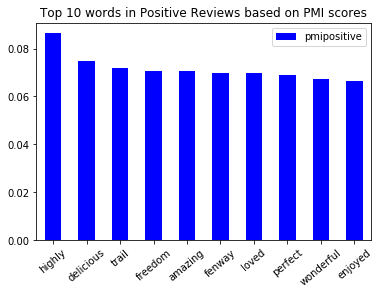

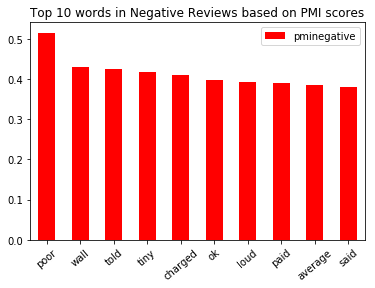

In [30]:
pmiPos_unigram.head(10).plot.bar(rot=40, color='b',
                                 title='Top 10 words in Positive Reviews based on PMI scores')
pmiNeg_unigram.head(10).plot.bar(rot=40, color='r',
                                 title='Top 10 words in Negative Reviews based on PMI scores')
plt.show()

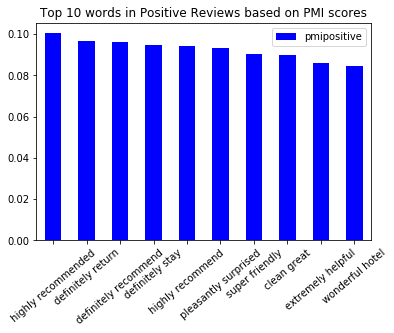

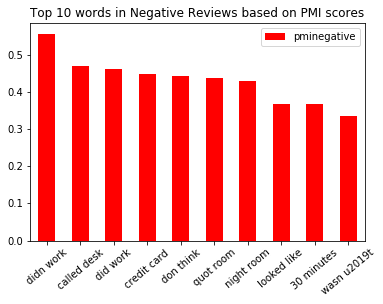

In [31]:
pmiPos_bigram.head(10).plot.bar(rot=40, color='b',
                                 title='Top 10 words in Positive Reviews based on PMI scores')
pmiNeg_bigram.head(10).plot.bar(rot=40, color='r',
                                 title='Top 10 words in Negative Reviews based on PMI scores')
plt.show()

### Pointwise Mutual Information seems like a good metric to summarize the reviews in n-gram tokens!
### By reading the n-gram tokens with high PMI scores for target variable, we can get a sense how much the reviewer did or didn't like the hotels. 

# Visualization
Sometimes, we can learn a lot about the data by visualizing.

## Historgrams

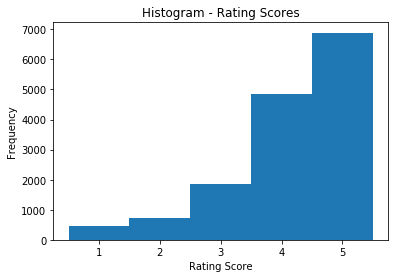

In [32]:
plt.xlabel('Rating Score')
hotelDf['ratingScore'].plot(kind='hist', title='Histogram - Rating Scores',
                            bins=np.arange(1,7)-0.5)
plt.show()

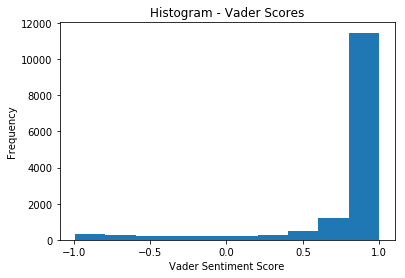

In [33]:
plt.xlabel('Vader Sentiment Score')
hotelDf['vaderScore'].plot(kind='hist', title='Histogram - Vader Scores', 
                           xticks=[-1.0, -0.5, 0.0, 0.5, 1.0])
plt.show()

/Users/vlad/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/vlad/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


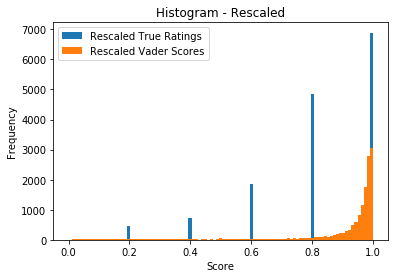

In [34]:
#Overlayed Histogram for GT rating and VD score
#Just for demonstrating, I am dividing the rating score by 5
x = [hotelDf['ratingScore'].as_matrix() / 5]
y = [(hotelDf['vaderScore'].as_matrix() + 1 )/ 2]
bins = np.linspace(0, 1, 100)
plt.hist(x, bins, label='Rescaled True Ratings')
plt.hist(y, bins, label='Rescaled Vader Scores')
plt.title('Histogram - Rescaled')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.legend(loc='upper left')
plt.show()

## Boxplots

In [35]:
#Plot top 5 side-by-side boxplot for top 5 ground truth rated hotel
tp5gthotel = ratingByHotel.sort_values('ratingScore', ascending=False).head(5).hotelName.as_matrix()

tempdf = hotelDf[(hotelDf.hotelName == tp5gthotel[0]) | (hotelDf.hotelName == tp5gthotel[1]) | 
         (hotelDf.hotelName == tp5gthotel[2]) | (hotelDf.hotelName == tp5gthotel[3]) | 
         (hotelDf.hotelName == tp5gthotel[4])]

/Users/vlad/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


/Users/vlad/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/Users/vlad/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


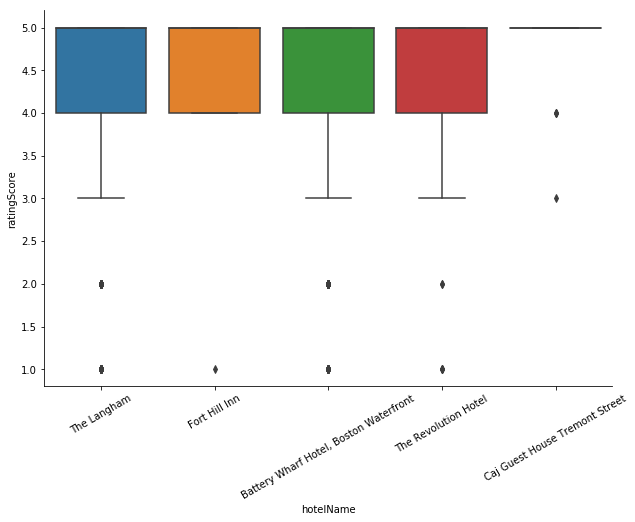

In [36]:
g = sns.factorplot(kind='box',        # Boxplot
               y='ratingScore',       # Y-axis - values for boxplot
               x='hotelName',        # X-axis - first factor
               data=tempdf,        # Dataframe 
               size=6,            # Figure size (x100px)      
               aspect=1.5,        # Width = size * aspect 
               legend_out=False)  # Make legend inside the plot

for ax in g.axes.flat:
    labels = ax.get_xticklabels() # get x labels
    ax.set_xticklabels(labels, rotation=30) # set new labels
    
plt.show()

/Users/vlad/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/Users/vlad/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


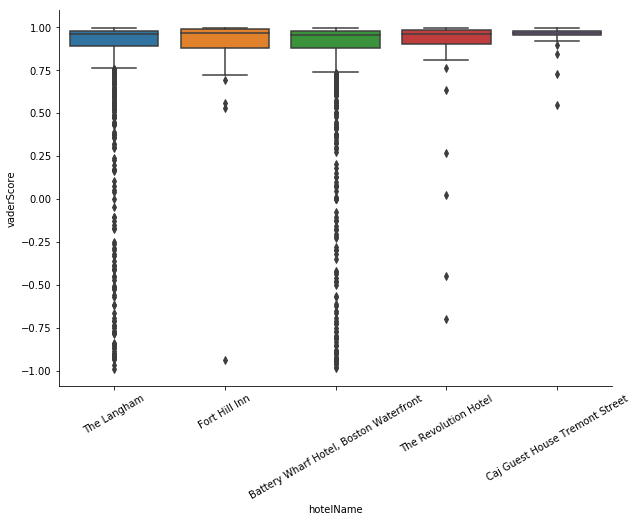

In [37]:
g = sns.factorplot(kind='box',        # Boxplot
               y='vaderScore',       # Y-axis - values for boxplot
               x='hotelName',        # X-axis - first factor
               data=tempdf,        # Dataframe 
               size=6,            # Figure size (x100px)      
               aspect=1.5,        # Width = size * aspect 
               legend_out=False)  # Make legend inside the plot

for ax in g.axes.flat:
    labels = ax.get_xticklabels() # get x labels
    ax.set_xticklabels(labels, rotation=30) # set new labels
    
plt.show()

## Scatterplots

/Users/vlad/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.
/Users/vlad/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


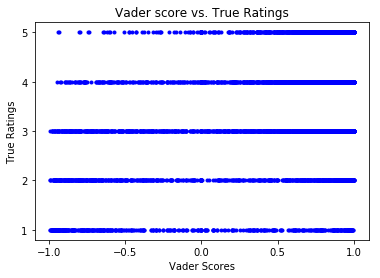

In [38]:
y = hotelDf['ratingScore'].as_matrix()
x = hotelDf['vaderScore'].as_matrix()
plt.title('Vader score vs. True Ratings')
plt.xlabel('Vader Scores')
plt.ylabel('True Ratings')
plt.xticks([-1, -0.5, 0, 0.5, 1])
plt.yticks([1,2,3,4,5])
plt.plot(x, y, "o", ms=3, color='b')
plt.show()